In this markdown, I will use split-conformal algorithm to find not only point prediction but a prediction interval for time series data using LSTM model

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler


In [7]:
import warnings
warnings.filterwarnings("ignore") # to ignore warnings

Now we will load and pre-process the data 

In [3]:
file_path = "data/train.csv"
data = pd.read_csv(file_path)

data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d') # Change date format
data.set_index('Date', inplace=True)

number_sold = data['number_sold']
number_sold = number_sold.dropna()
print(f"Number of missing values in number_sold: {number_sold.isnull().sum()}") # number of missing values

number_sold = number_sold[1:3000] # As the dataset is large, we will only work with the first 3000 rows


Number of missing values in number_sold: 0


Now we will plot the number of products sold

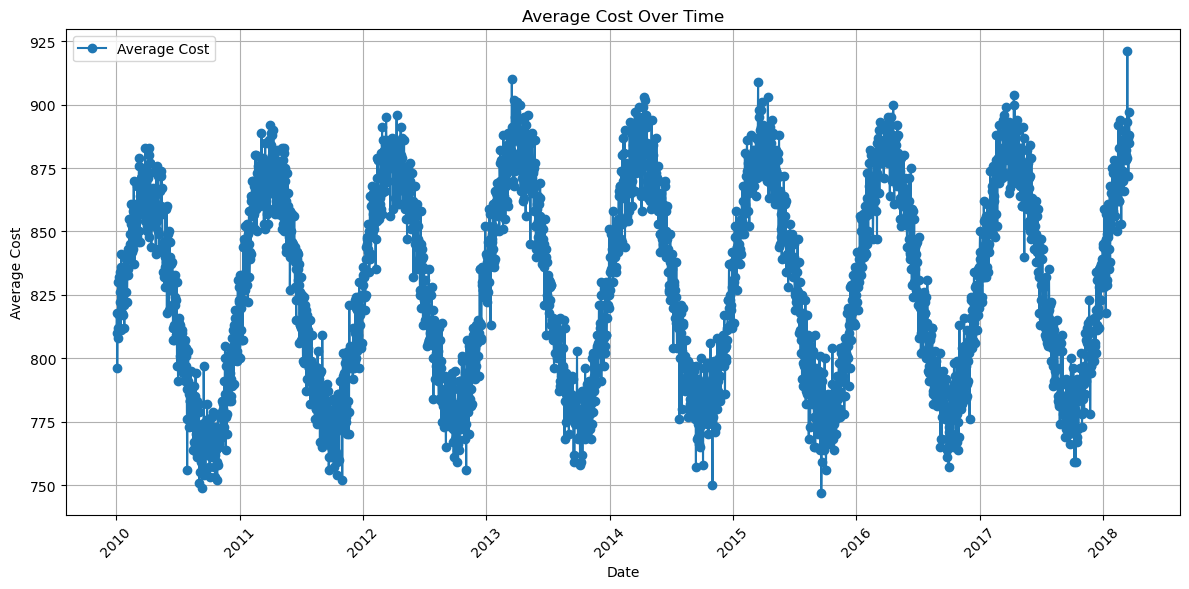

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(number_sold, marker='o', label='Average Cost')
plt.title('Average Cost Over Time')
plt.xlabel('Date')
plt.ylabel('Average Cost')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Next we will fit a LSTM model

In [142]:
# ------------------ PyTorch LSTM benchmark ------------------
# hyper-parameters
forecast_horizon = 200
look_back = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # prepare & scale
series = number_sold.values.reshape(-1,1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series)


def create_seq(data, lb):
    X, y = [], []
    for i in range(len(data) - lb):
        X.append(data[i:i+lb])      # no extra axis
        y.append(data[i+lb])
    return (torch.tensor(X, dtype=torch.float32),   # (n_samples, lb, 1)
            torch.tensor(y, dtype=torch.float32))


X_all, y_all = create_seq(series_scaled, look_back)
X_train, y_train = X_all[:-forecast_horizon], y_all[:-forecast_horizon]
X_val,  y_val  = X_all[-forecast_horizon:], y_all[-forecast_horizon:]

train_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=False)

# model
class LSTMNet(nn.Module):
    def __init__(self, in_size, hidden_size, num_layers, dropout):
        super().__init__()
        # multi-layer LSTM with dropout between layers
        self.lstm = nn.LSTM(
            input_size=in_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        # final dropout before the linear head
        self.drop = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, features]
        out, _ = self.lstm(x)                # out: [batch, seq_len, hidden_size]
        last = out[:, -1, :]                 # take last time step
        last = self.drop(last)               # apply dropout
        return self.fc(last)

model = LSTMNet(in_size=1, hidden_size=16, num_layers=1, dropout=0.1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# training loop
for epoch in range(40):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).unsqueeze(-1)
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d} – train loss: {total_loss/len(train_loader):.4f}")

# forecast
model.eval()
with torch.no_grad():
    X_val_dev = X_val.to(device)
    pred_scaled = model(X_val_dev).cpu().numpy()



Epoch   0 – train loss: 0.0532
Epoch  10 – train loss: 0.0061
Epoch  20 – train loss: 0.0054
Epoch  30 – train loss: 0.0051


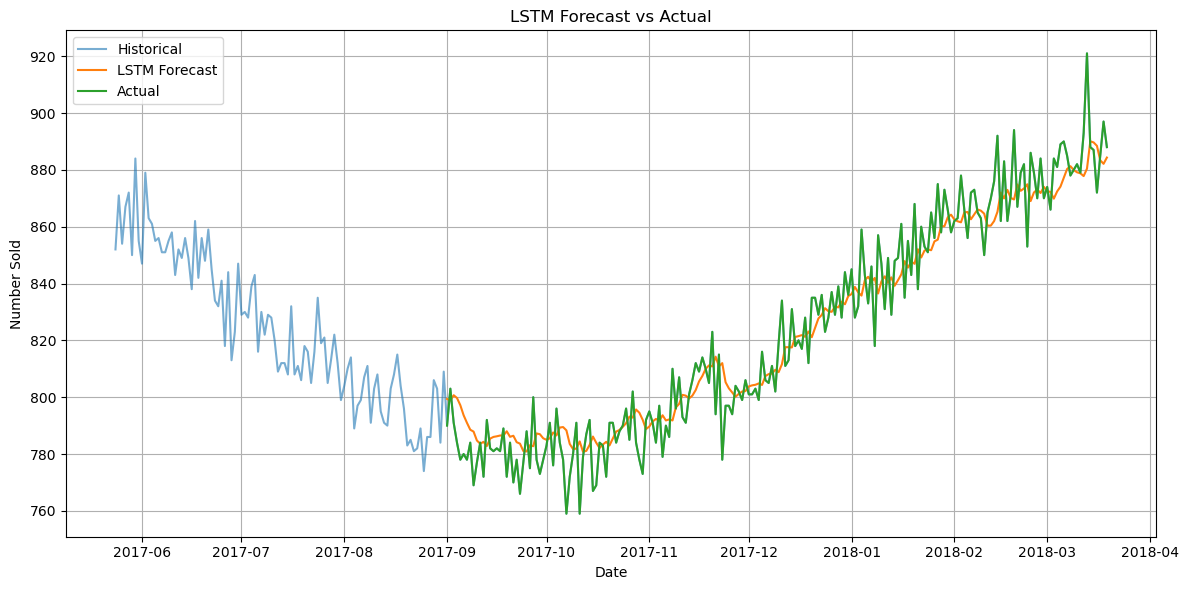

In [144]:
# —— Invert scaling & plot LSTM forecasts —— 
# pred_scaled: (forecast_horizon,1) from your eval block
pred_scaled = pred_scaled.reshape(-1, 1)
lstm_pred   = scaler.inverse_transform(pred_scaled).flatten()

# true scaled → actual
y_val_scaled  = y_val.unsqueeze(-1).cpu().numpy().reshape(-1, 1)
y_val_actual  = scaler.inverse_transform(y_val_scaled).flatten()

# get the dates for the forecast horizon
forecast_dates = number_sold.index[-forecast_horizon:]

# Plot
plt.figure(figsize=(12,6))
plt.plot(number_sold.index[-300:], number_sold.values[-300:], label='Historical', alpha=0.6)
plt.plot(forecast_dates, lstm_pred,   '-', label='LSTM Forecast')
plt.plot(forecast_dates, y_val_actual, '', label='Actual')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Now we will find the non-conformity scores as well as  lower and upper prediction bound using miscoverage value $\alpha$

In [196]:
alpha = 0.3  # miscoverage value
cal_resid = np.abs(lstm_pred - y_val_actual)
q = np.quantile(cal_resid, 1 - alpha)  

Now we will check the coverage on test set

In [217]:
test_data = pd.read_csv("/Users/souvikbag/Library/CloudStorage/OneDrive-UniversityofMissouri/Research/dementia/data/test.csv")

In [218]:
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%Y-%m-%d') # Change date format
test_data.set_index('Date', inplace=True)
test_data = test_data[:300]
test = test_data['number_sold'].values.reshape(-1,1)
# test = test[:500]  # As the dataset is large, we will only work with the first 500 rows
test_series_scaled = scaler.fit_transform(test)


In [219]:
X_test, y_test = create_seq(test_series_scaled, look_back)

In [220]:
test_ds = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)


In [221]:
model.eval()
X_test = X_test.to(device)
model = model.to(device)
with torch.no_grad():
    y_test_pred = model(X_test).cpu().numpy()

# invert scaling
y_test_pred = y_test_pred.reshape(-1, 1)
y_test_pred  = scaler.inverse_transform(y_test_pred).flatten()
# y_test = y_test.to(device).unsqueeze(-1).cpu().numpy().flatten()
# # now compute your intervals

# true scaled → actual
y_test_scaled  = y_test.unsqueeze(-1).cpu().numpy().reshape(-1, 1)
y_test_actual  = scaler.inverse_transform(y_test_scaled).flatten()
lower = y_test_pred - q
upper = y_test_pred + q


Now we will calculate the coverage

In [222]:
coverage = np.mean((y_test_pred - q <= y_test_actual) & (y_test_actual <= y_test_pred + q))
avg_width = np.mean((upper - lower))
print(f"Coverage ≈ {coverage:.3f}, Avg width ≈ {avg_width:.2f}")


Coverage ≈ 0.693, Avg width ≈ 22.34



Below we generate conformal prediction intervals for miscoverage levels  
α = 0.05, 0.1, 0.2, and 0.3, and report both the empirical coverage and the average interval width. 

As the allowed miscoverage α increases, the intervals become narrower and the observed coverage goes down.
Note that conventional conformal methods assume exchangeability, which is violated in time‐series data—making it an interesting challenge to adapt these techniques for forecasting applications such as dementia

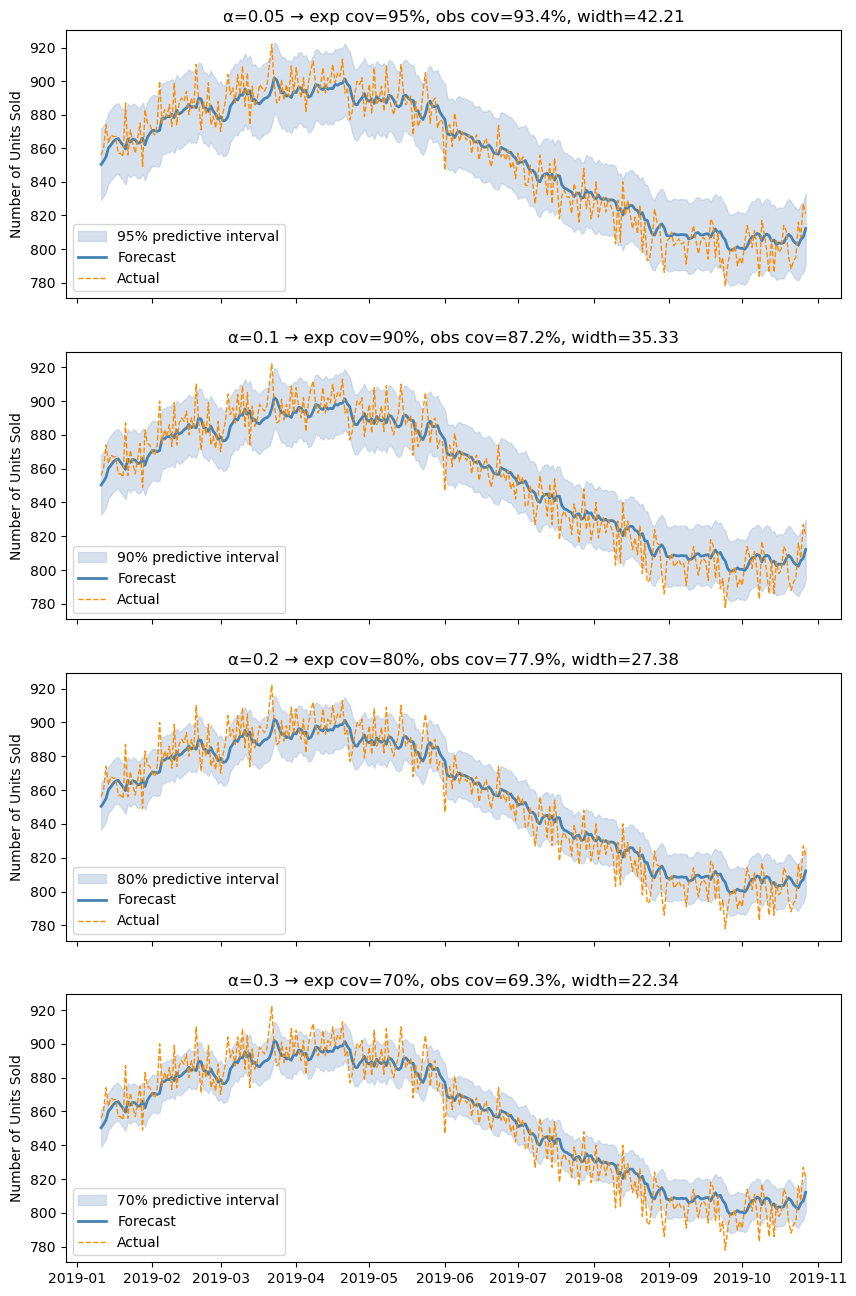

In [237]:
# Plot conformal prediction intervals for multiple alphas in one column
alphas = [0.05, 0.1, 0.2, 0.3]
# calibration residuals from validation set
cal_resid = np.abs(lstm_pred - y_val_actual)

# align dates with your test‐set forecasts
dates = test_data.index[look_back : look_back + len(y_test_pred)]

fig, axes = plt.subplots(nrows=len(alphas), ncols=1,
                         figsize=(10, 4*len(alphas)), sharex=True)

for ax, alpha in zip(axes, alphas):
    # compute conformal threshold
    q = np.quantile(cal_resid, 1 - alpha)
    lower = y_test_pred - q
    upper = y_test_pred + q

    # observed coverage & avg width
    obs_cov = np.mean((y_test_actual >= lower) & (y_test_actual <= upper))
    avg_w  = np.mean(upper - lower)

    # shaded interval
    ax.fill_between(dates, lower, upper,
                    color='lightsteelblue', alpha=0.5,
                    label=f'{100*(1-alpha):.0f}% predictive interval')

    # point forecast & true
    ax.plot(dates, y_test_pred,   color='steelblue', lw=2, label='Forecast')
    ax.plot(dates, y_test_actual, color='darkorange', linestyle='--', lw=1, label='Actual')

    # annotate with expected vs observed coverage and width
    ax.set_title(
        f"α={alpha} → exp cov={(1-alpha)*100:.0f}%, "
        f"obs cov={obs_cov*100:.1f}%, width={avg_w:.2f}"
    )
    ax.set_ylabel('Number of Units Sold')  
    ax.legend(loc='lower left')